# Visualizing   Topographic Noise

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

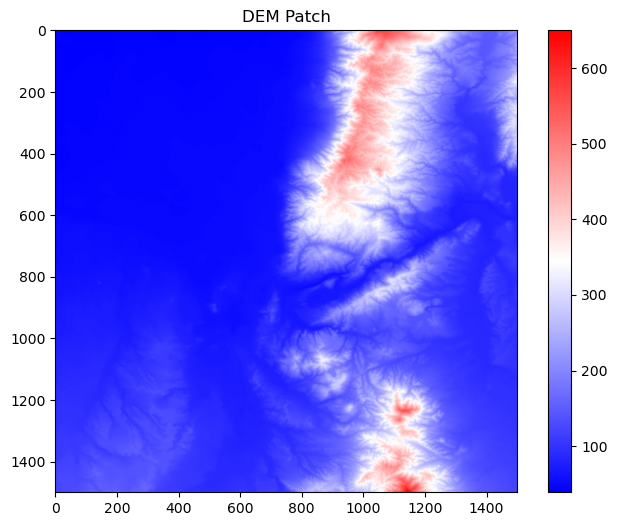

In [17]:
def LoadDem(dem_path):
    data_type = np.dtype('>f4')
    raw_data = np.fromfile(dem_path, dtype=data_type)
    dem_data = raw_data.reshape((12602, 11702))
    return dem_data


size = (1500, 1500)

full_dem = LoadDem('Kyoto-Osaka.dehm')
max_y = full_dem.shape[0] - size[0]
max_x = full_dem.shape[1] - size[1]

start_y = random.randint(0, max_y)
start_x = random.randint(0, max_x)

dem_patch = full_dem[
    start_y : start_y + size[0],
    start_x : start_x + size[1]
]

def plot_patch(patch, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(patch, cmap='bwr')
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_patch(dem_patch, 'DEM Patch')

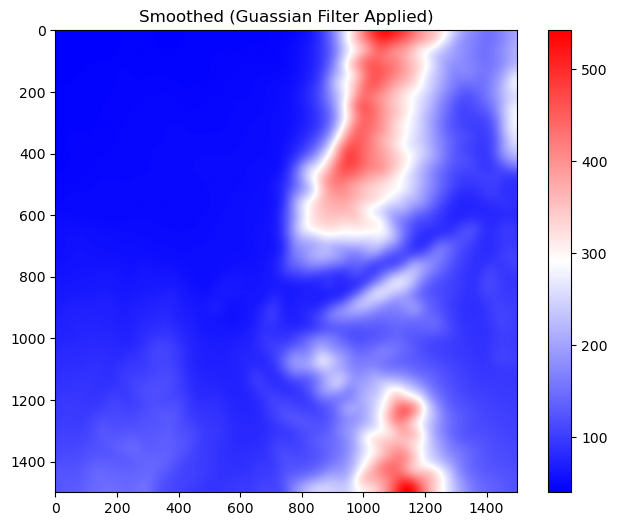

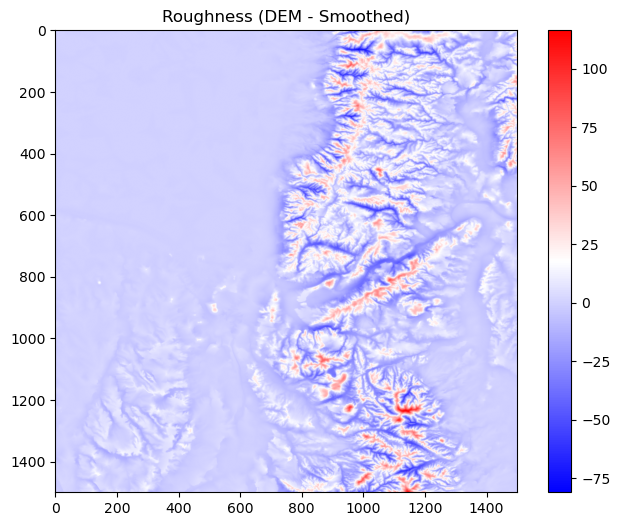

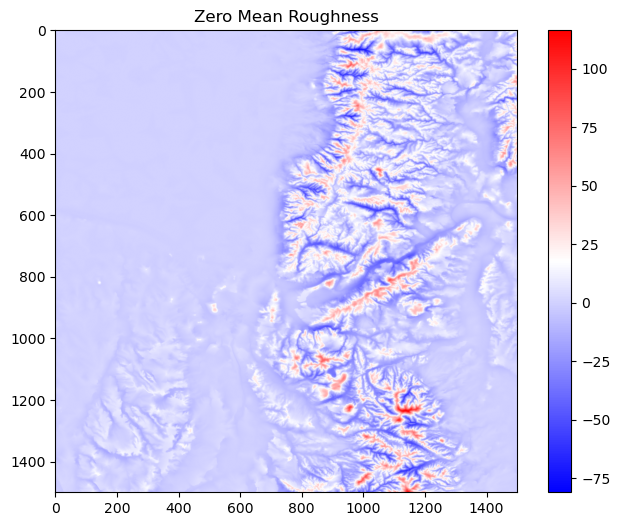

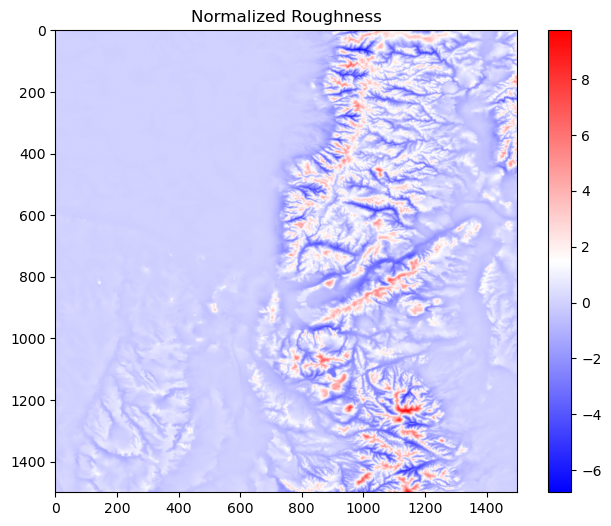

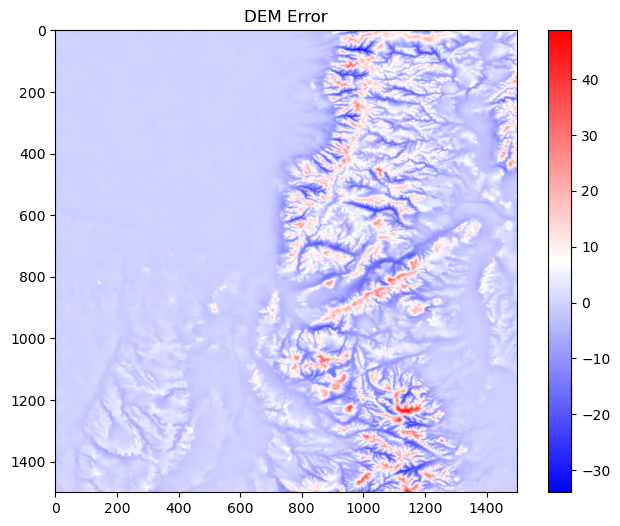

array([[ 0.10514839,  0.10569048,  0.10662435, ...,  2.3217301 ,
         3.1726909 ,  3.6610794 ],
       [ 0.10545381,  0.10599431,  0.10692658, ...,  2.1926    ,
         2.9596853 ,  3.0707839 ],
       [ 0.10591596,  0.10645644,  0.10738552, ...,  1.8083699 ,
         2.4496193 ,  2.4768486 ],
       ...,
       [ 0.12245857,  0.03642095, -0.01008709, ..., -0.4988116 ,
        -0.53588176, -0.57531863],
       [ 0.24898843,  0.16295722,  0.03260231, ..., -0.45871592,
        -0.4957925 , -0.57714796],
       [ 0.3333566 ,  0.20539714,  0.07504865, ..., -0.41758403,
        -0.49657926, -0.53601927]], shape=(1500, 1500), dtype=float32)

In [18]:
def GenerateDemError(dem_patch, std=20.0):
    smoothed_dem = gaussian_filter(dem_patch, sigma=20)
    plot_patch(smoothed_dem, 'Smoothed (Guassian Filter Applied)')
    roughness = dem_patch - smoothed_dem
    plot_patch(roughness, 'Roughness (DEM - Smoothed)')
    zero_mean_roughness = roughness - roughness.mean()
    plot_patch(zero_mean_roughness, 'Zero Mean Roughness')
    roughness_std = zero_mean_roughness.std()
    if roughness_std > 1e-9:
        normalized_roughness = zero_mean_roughness / roughness_std
    else:
        normalized_roughness = zero_mean_roughness
    plot_patch(normalized_roughness, 'Normalized Roughness')
    dem_error = normalized_roughness * std
    plot_patch(dem_error, 'DEM Error')
    return dem_error

GenerateDemError(dem_patch, std=5.0)